# Analisis comparativo de los metodos de regresion
## Analitica de datos
#### Daniel Cardona Velasquez
#### Universidad Nacional De Colombia.

A continuacion presentaremos un analisis comparativo de algunos metodos de regresion ya implementados por algunas librerias en python para el entrenamiento de modelos predictivo, la idea pricncipal es predecir el numero de contagiados por COVID-19 del dia siguiente en colombia. En este caso en particualar, trabajaremos en una base de datos sobre el Covd-19, previamente filtrada y depurada para su entrenamiento y analisis.

In [ ]:
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c3c0c08e25b401e701bb265b143f89bafdc31e064218dc858199303a4852d909
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


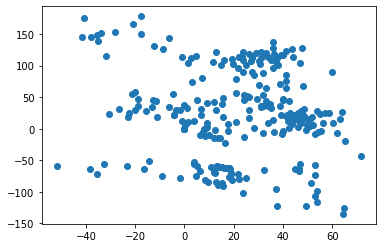

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

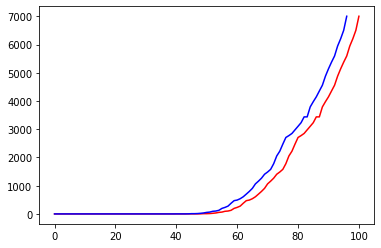

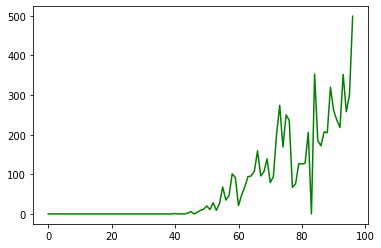

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
w = 3
X,y = covid_win(serie,w=w)
X_d,y_d = covid_win(serie_d,w=w)

plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')



# Entrenamiento de regresor para covid 19 - Colombia
# Análisis exploratorio - visualización en 2D PCA
# Validación cruzada y anidada (pocos datos)

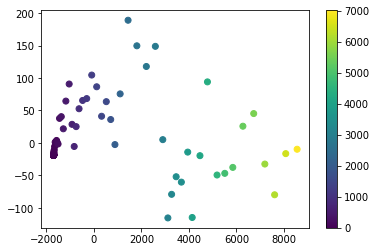

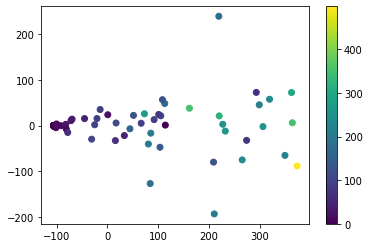

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#red = TSNE(n_components = 2,perplexity=10)
#red_d = TSNE(n_components = 2,perplexity=10)

red = PCA()
red_d = PCA()


z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()


plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()


In [ ]:
red_d.explained_variance_ratio_

array([0.86636436, 0.07168599, 0.06194964])

$$w^* = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y $$

$$y_n = \phi_n w^*$$


$\lambda$: hyperparameter

$\Phi(x)=\mathcal{N}(x|\mu,\sigma^2)$

$\mu,\sigma$ hyperparameters

$w$: model's parameter

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
#pocos datos y mucha incertidumbre, validación cruzada anidada
Xdata, ydata = X,y
#conjunto de entrenamiento y conjunto de test
X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(67, 3)
(30, 3)


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', LinearRegression())],

         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', Ridge())],

         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', Lasso())],

         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', ElasticNet())],

         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', KernelRidge(kernel = 'rbf'))], #clasificador


          [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', KernelRidge(kernel='polynomial'))], #clasificador


           [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', KernelRidge(kernel='sigmoid'))] #clasificador

         ]

#parametros a buscar por busqueda por grilla
parameters =[
             {'reg__fit_intercept':[0.5,1,1.5,2,2.5,3],
              'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },

             {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
              'reg__fit_intercept':[0.5,1,1.5,2,2.5,3],
              'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },

              {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
              'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },

             {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
              'reg__l1_ratio':[5e-3,5e-2,5e-1,5,10,100],
              'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },

             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
             'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },


             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
             'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },


             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
             'rep__n_components':[0.5,0.75,0.9,1,2,3]
             },
              ]

label_model = ['NorSC-PCA-LM', 'NorSC-PCA-LMRidge', 'NoSC-PCA-LMLasso', 'NorSC-PCA-LMEN', 'NorSC-PCA-KRRBF', 'NorSC-PCA-KRPoly', 'NorSC-PCA-KRSig']


In [ ]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
maev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion
#############################
for j in range(Niter): #outter loop
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          maev[j,r] = mae(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('mae:',maev[j,r])

      best_estimators[j] = list_est #guardar mejores modelos
      best_hyperpar[j] = list_hyper #mejores hyperparametros

      savedata = {
          'acc':maev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            }

      dump(savedata,'covid19_1.joblib')



Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1945s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0362s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0636s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  79 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0890s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 152 out of 180 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    2.6s finished
[Parallel(n_jobs=5)

it 1/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 42.90448675979251
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1579s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_job

it 1/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 43.315437772864506
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0917s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0883s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0363s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 1/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 42.91567008373955
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1159s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1045s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1846s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.03

it 1/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 2}
mae: 51.67331189958749
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1030s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jo

it 1/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
mae: 38.89166077571099
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1003s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0773s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1038 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_job

it 1/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 38.11432882714046
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0629s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1010s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 954 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1014 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1044 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1061 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.6s finished
/usr/local/lib/python3.6/dis

it 1/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 35.66102478659159
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0931s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0393s.) Setting batch_size=4.


it 2/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 42.841121351825066
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0716s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1051s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1632s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent wo

it 2/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 42.82594142036825
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0681s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1051s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0103s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0389s.) Setting batch_size=4.


it 2/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 3}
mae: 42.83702841530796
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0774s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1035s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1038 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 2/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 3}
mae: 48.744646667817385
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0528s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1696s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 2/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 37.616817658221194
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0814s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1307s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 2/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 40.306169117184616
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0795s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 254 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 550 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 670 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 926 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1872s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Sing

it 2/10-Modelo 7/7
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 44.95988834205835
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0786s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1830s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 128 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=2.


it 3/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 55.57254037317675
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0430s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0610s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1219s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1730s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.7

it 3/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 54.27512674064966
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1900s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0441s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0588s.) Setting batch_size=8.


it 3/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 3}
mae: 55.522157125720135
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1154s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1687s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 900 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 926 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  

it 3/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 3}
mae: 53.948093236289296
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1483s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_s

it 3/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 43.49820123912529
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0683s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1311s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1683s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 674 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 978 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend 

it 3/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 30.668244312299553
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 350 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 454 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 558 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 798 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 934 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Pa

it 3/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 30.932091287553583
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0490s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0807s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0062s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0062s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0387s.) Setting batch_size=8.


it 4/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 51.85657106149414
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1427s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 554 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 762 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 970 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1030 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 4/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 3}
mae: 50.27876389681912
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0410s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0789s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1063s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=

it 4/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 3}
mae: 51.80246448120682
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1548s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1537s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 900 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  

it 4/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 3}
mae: 46.69658325888574
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1253s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1010s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1850s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 900 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent wo

it 4/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 43.0747452128734
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0505s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0732s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1361s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    3.1s


it 4/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 33.62629717755546
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0760s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 274 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 362 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 466 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 570 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 690 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 810 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 946 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1951s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 1040 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1071 out of 10

it 4/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 37.85499400345499
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0712s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0375s.) Setting batch_size=4.


it 5/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 62.19738538747094
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0515s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 5/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 61.808952664809084
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1434s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0300s.) Setting batch_size=4.


it 5/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 62.18790867313991
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0912s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1267s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1782s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 930 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent wo

it 5/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 2}
mae: 61.374703013772105
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0518s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1161s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 5/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 3}
mae: 57.69980893129153
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0804s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1548s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 106 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 362 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 538 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 746 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 954 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1029 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent work

it 5/10-Modelo 6/7
best hyper {'reg__alpha': 0.01, 'reg__gamma': 100, 'rep__n_components': 2}
mae: 71.38190039594969
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0778s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1540s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares s

it 5/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 50.11148134466445
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0492s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1078s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 134 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished


it 6/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 59.652146788075136
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0390s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0632s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1451s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | ela

it 6/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 59.75898475148851
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1249s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0313s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 6/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 59.65525029824107
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0619s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1554s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1937s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 986 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.00

it 6/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 2}
mae: 63.68704717958632
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1316s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jo

it 6/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 45.717810576603505
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0822s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1232s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jo

it 6/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 2}
mae: 55.42942755878982
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0430s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1880s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 554 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 762 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 970 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1045 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:

it 6/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 42.44126453134722
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0687s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 144 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 155 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


it 7/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 39.40304788500808
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0533s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1761s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1687s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 674 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 978 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend 

it 7/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 39.745593735149654
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1095s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0439s.) Setting batch_size=4.


it 7/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 39.41454236820876
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0931s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1039s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 7/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 2}
mae: 48.318230309308525
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1165s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1161s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 7/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 2}
mae: 42.42186511067363
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0708s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1430s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 302 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 478 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 686 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 894 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computat

it 7/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 32.86159308825718
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1728s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1870s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 674 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 881 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 949 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1071 out of 1080 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singula

it 7/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 31.42631121884903
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0424s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0583s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1599s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Ba

it 8/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 50.801062460655004
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1572s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1978s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  

it 8/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 51.186178673454926
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1130s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0078s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0361s.) Setting batch_size=4.


it 8/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 50.81279068960236
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0781s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0920s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jo

it 8/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 3}
mae: 59.07524765884365
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0747s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1609s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_si

it 8/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 2}
mae: 56.91737928050951
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0781s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1109s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0855s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1023 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1038 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
[Parall

it 8/10-Modelo 6/7
best hyper {'reg__alpha': 0.1, 'reg__gamma': 10, 'rep__n_components': 2}
mae: 42.3145130175441
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0697s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1706s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: S

it 8/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 42.428813245119336
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0498s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1337s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0367s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 9/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 36.90632261164626
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0636s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1253s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1679s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 870 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.01

it 9/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 37.17935807763524
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1303s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0526s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s


it 9/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 36.91463633207595
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1995s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 318 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 702 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0394s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0

it 9/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 3}
mae: 47.56695272079888
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1207s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jo

it 9/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
mae: 46.396783256888256
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0578s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1416s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
[Paralle

it 9/10-Modelo 6/7
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 3}
mae: 47.75203934011859
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0852s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0921s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1856s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 374 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 726 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 902 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 988 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1018 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1048 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. 

it 9/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 1, 'rep__n_components': 0.5}
mae: 33.216969123059364
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0756s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0829s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0416s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 10/10-Modelo 1/7
best hyper {'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 41.2348259981234
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0593s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1030s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_s

it 10/10-Modelo 2/7
best hyper {'reg__alpha': 0.001, 'reg__fit_intercept': 0.5, 'rep__n_components': 2}
mae: 41.511070488891214
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0676s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0359s.) Setting batch_size=4.


it 10/10-Modelo 3/7
best hyper {'reg__alpha': 0.001, 'rep__n_components': 2}
mae: 41.24200092431623
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0829s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1462s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1511s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 900 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent wo

it 10/10-Modelo 4/7
best hyper {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5, 'rep__n_components': 2}
mae: 51.774125884390244
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0977s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 1008 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jo

it 10/10-Modelo 5/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 43.99194428359181
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0884s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1303s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 993 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 1053 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_si

it 10/10-Modelo 6/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 42.57609938257195
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0661s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 984 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 1029 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1044 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1061 tasks      | elapsed:    3.5s


it 10/10-Modelo 7/7
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 2}
mae: 44.1827700372565


[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Por Niter de outter loop tengo valores de los hyperparameters

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = moda/mediana(\gamma_i) = 0.01$$

Tomo todos los datos, entreno sobre todo el conjunto con los parametros encontrados utilizando validación cruzada anidad

$$\theta^*/w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,\theta^*/w^*)$$

### A continuacion se puede ver un grafico comparativo de los errores de todos los modelos y con el se puede decidir cual es el modelo mas acertado.

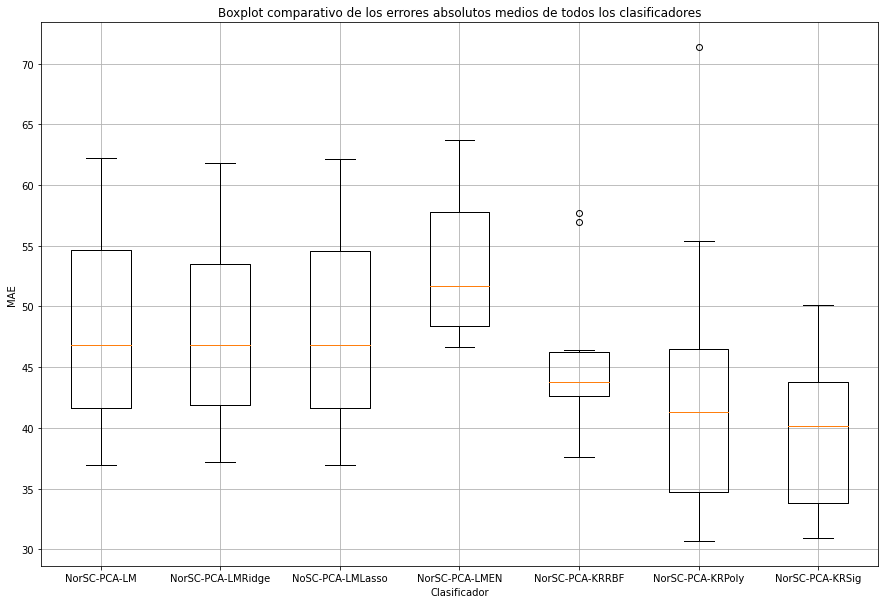

In [ ]:
#Comparacion de los errores medios absolutos de todos los clasificadores
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)
plt.boxplot(maev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.xlabel("Clasificador")
plt.ylabel("MAE")
plt.title("Boxplot comparativo de los errores absolutos medios de todos los clasificadores")
plt.grid()
plt.show()

### Luego de ver el grafico comparativo de los errores de los modelos vamos a entrenar un modelo para cada uno de los regresores con los mejores parametros encontrados por el GridSerchCV, se mostrara cuales fueron esos parametros y posteriormente se hara una prediccion de contagiados por COVID-19 al dia siguiente con cada uno de ellos. Al final podremos comparar sus predicciones y cual es la mas acertada.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


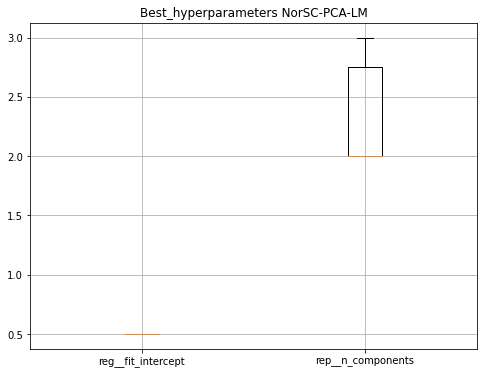

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Modes=  [0.5 2. ]


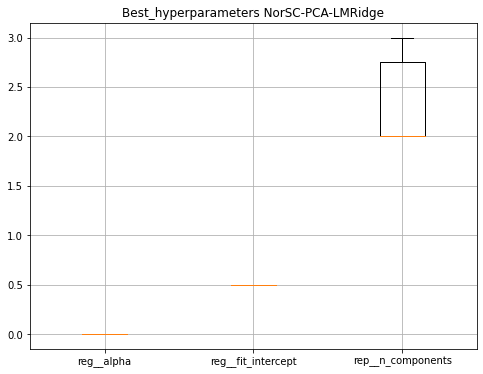

Modes=  [1.e-03 5.e-01 2.e+00]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


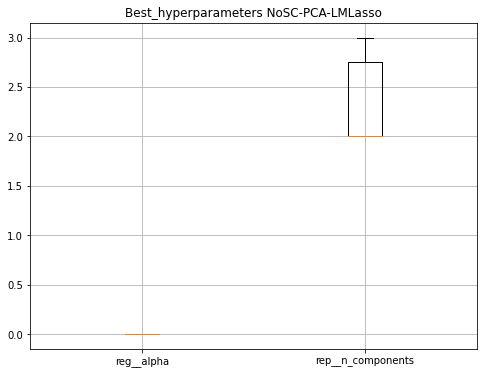

Modes=  [1.e-03 2.e+00]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


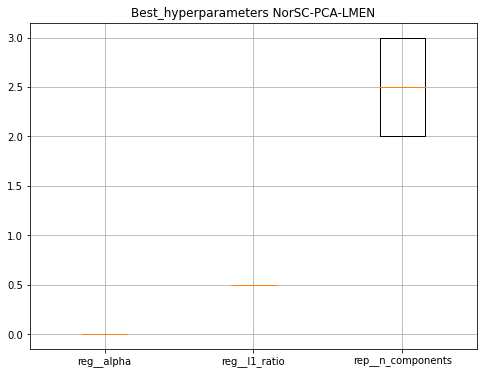

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Modes=  [1.e-03 5.e-01 2.e+00]


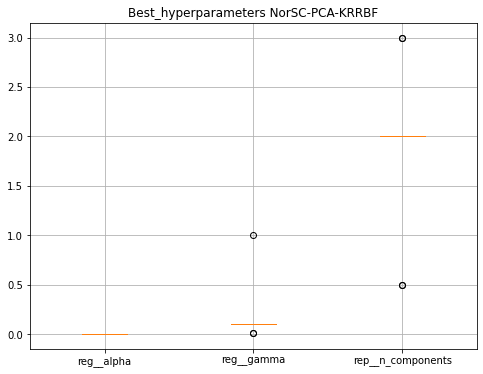

Modes=  [1.e-03 1.e-01 2.e+00]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


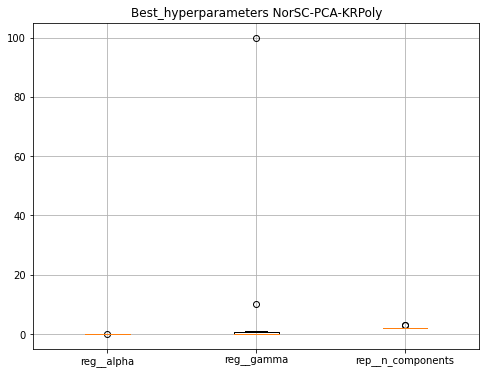

Modes=  [1.e-03 1.e-01 2.e+00]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


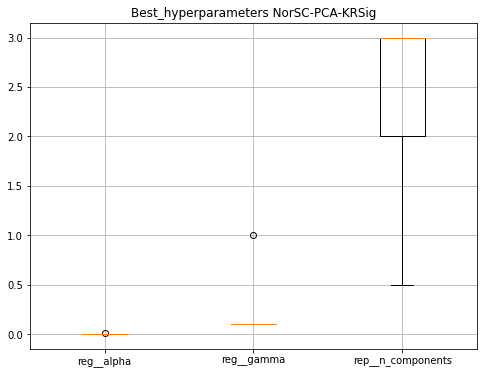

Modes=  [1.e-03 1.e-01 3.e+00]


In [ ]:
## Mejores parametros por modelo

from scipy.stats import mode
from datetime import date



for q in range (0,len(steps)):

  r = q #hyperparameters model q
  nh = len(best_hyperpar[0][r])
  hyperpar_r = np.zeros((Niter,nh))
  for i in range(Niter):
    for j in range(nh):
      hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])


  #revisar numero entero para realizar casting
  aa = list(best_hyperpar[0][r].keys())
  c = -1
  for i in range(len(aa)):
      if aa[i].find('n_components') > -1:
        c = i

  plt.figure(figsize=[8,6])
  plt.boxplot(hyperpar_r)
  plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
  plt.title('Best_hyperparameters '+label_model[r])
  plt.subplot()
  plt.grid()
  plt.show()

  mode_hyper = mode(hyperpar_r,axis=0)[0][0]
  print("Modes= ", mode_hyper)




Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-LM = [7671.95827573]


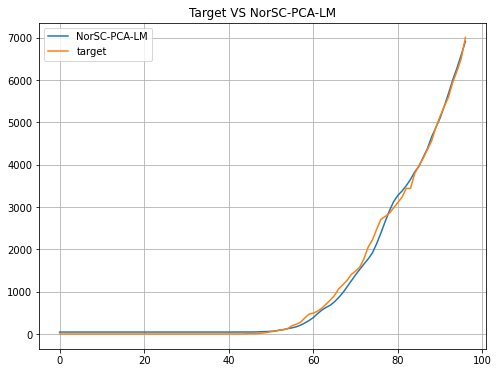

Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-LMRidge = [7794.47199852]


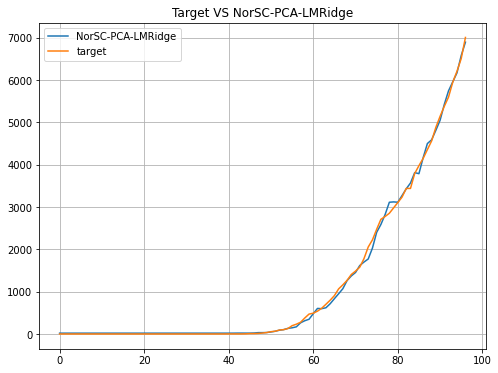

Predicción contagiados covid19  2020-05-03 con el modelo NoSC-PCA-LMLasso = 7671.956259163704


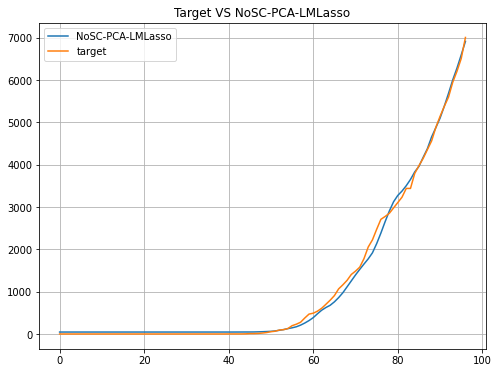

Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-LMEN = 7727.827327248075


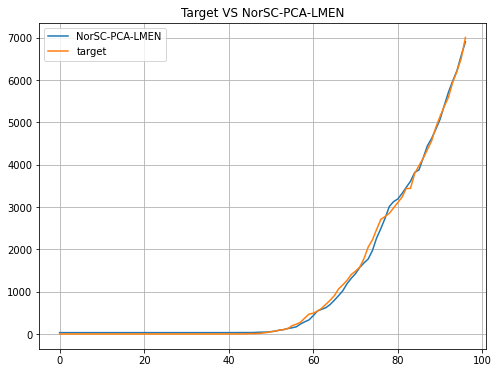

Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-KRRBF = [6598.3090598]


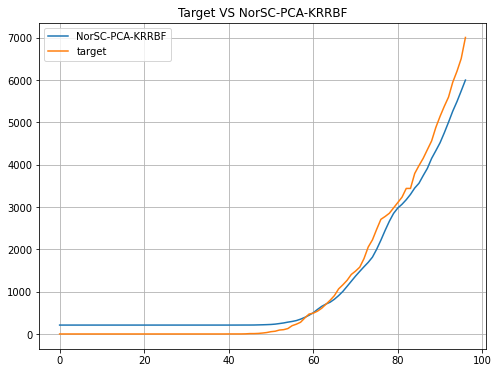

Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-KRPoly = [7047.77754845]


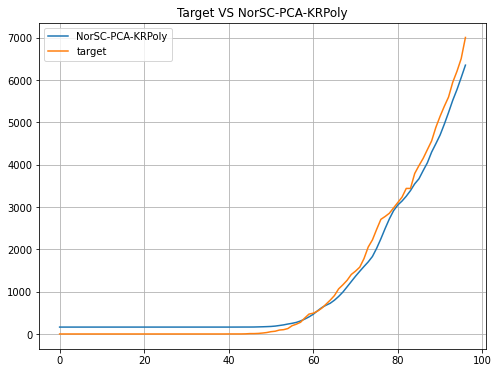

Predicción contagiados covid19  2020-05-03 con el modelo NorSC-PCA-KRSig = [4719.8075348]


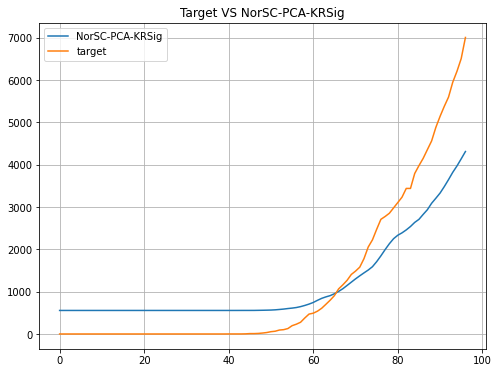

In [ ]:
# Entrenamiento y prdiccion con todos los modelos
for q in range (0,len(steps)):
  r = q
  #entrenar con mejores hyperparametros
  model_f = Pipeline(steps[r])
  paramsf = parameters[r]
  hyperl = list(parameters[r].keys())
  nh = len(hyperl)
  for j in range(nh):
    if j ==c:
      paramsf[hyperl[j]] = int(mode_hyper[j])
    else:
      paramsf[hyperl[j]] = mode_hyper[j]

  model_f.set_params(**paramsf)
  model_f.fit(Xdata,ydata) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

  print('Predicción contagiados covid19 ',date.today(),'con el modelo', label_model[r], '=',model_f.predict(serie[len(serie)-w:].reshape(1,-1))[0])


  #curva predicción sobre modelo  final
  plt.figure(figsize=[8,6])
  plt.plot(model_f.predict(Xdata),label=label_model[r])
  plt.plot(ydata,label='target')
  plt.title('Target VS '+label_model[r])
  plt.grid()
  plt.legend()
  plt.show()